# Cloudy vs. clear prediction

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = utils.plot_params()
plt.rcParams.update(params)

## [Dowload data](https://www.dropbox.com/sh/r1kpecmjvg9zjhm/AACVP-xPzKePexXSG6tl3AKWa?dl=1)

Unzip this into a folder named `data` in the same level as this notebook

## Load

In [3]:
df_wakeford = pd.read_table(
    "data/cloudy_vs_clear/H2O_J_data.txt", header=1, sep="\s+", index_col="Name"
)
display(df_wakeford.head())
df_wakeford.dtypes

,T,logg,H2O-J,H2O-J_unc
Name,,,,
GJ436,669.0,3.10,0.339500,0.266522
GJ1214,547.0,2.94,0.003296,0.056763
HAT-P-01,1322.0,2.93,1.337013,0.679367
HAT-P-11,838.0,3.06,2.499212,0.504664
HAT-P-12,955.0,2.75,0.217148,0.650651


T            float64
logg         float64
H2O-J        float64
H2O-J_unc    float64
dtype: object

In [4]:
df_wakeford

,T,logg,H2O-J,H2O-J_unc
Name,,,,
GJ436,669.0,3.10,0.339500,0.266522
GJ1214,547.0,2.94,0.003296,0.056763
HAT-P-01,1322.0,2.93,1.337013,0.679367
HAT-P-11,838.0,3.06,2.499212,0.504664
HAT-P-12,955.0,2.75,0.217148,0.650651
HAT-P-17,792.0,3.11,1.510989,0.672787
HAT-P-18,841.0,2.73,1.644092,0.401364
HAT-P-26,1001.0,2.65,1.384714,0.239845
HAT-P-32,1801.0,2.78,1.109273,0.395724


In [5]:
df_southworth = pd.read_table(
    "https://www.astro.keele.ac.uk/jkt/tepcat/allplanets-csv.csv",
    sep=r"\s*,\s*",
    engine="python",
    index_col="System",
)
display(df_southworth.head())
df_southworth.dtypes

,Teff,err,err.1,[Fe/H],erru,errd,M_A,errup,errdn,R_A,...,errup.8,errdn.6,rho_b,errup.9,errdn.7,Teq,err.2,err.3,Discovery_reference,Recent_reference
System,,,,,,,,,,,,,,,,,,,,,
55_Cnc_e,5172,18,18,0.35,0.10,0.10,0.873,0.051,0.035,0.954,...,2.1,1.9,4.71,0.56,0.53,2349.0,188.0,193.0,2011ApJ...737L..18W,arXiv:1908.06299
pi_Men,5998,62,62,0.09,0.04,0.04,1.070,0.040,0.040,1.170,...,1.9,9.5,2.10,0.40,0.40,1170.0,2.8,4.3,arXiv:1809.05967,arXiv:2007.06410
AD_3116,3184,29,29,0.14,0.10,0.10,0.276,0.020,0.020,0.290,...,-1.0,-1,-1.00,-1.00,-1.00,1669.0,244.0,258.0,2017ApJ...849...11G,2017ApJ...849...11G
AU_Mic_b,3700,100,100,-1.00,-1.00,-1.00,0.500,0.030,0.030,0.750,...,-1.0,-1,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,arXiv:2006.13248,arXiv:2012.13238
AU_Mic_c,3700,100,100,-1.00,-1.00,-1.00,0.500,0.030,0.030,0.750,...,-1.0,-1,-1.00,-1.00,-1.00,-1.0,-1.0,-1.0,arXiv:2012.13238,arXiv:2012.13238


Teff                     int64
err                      int64
err.1                    int64
[Fe/H]                 float64
erru                   float64
errd                   float64
M_A                    float64
errup                  float64
errdn                  float64
R_A                    float64
errup.1                float64
errdn.1                float64
loggA                  float64
errup.2                float64
errdn.2                float64
rho_A                  float64
errup.3                float64
errdn.3                float64
Period                 float64
e                      float64
errup.4                float64
errdown                float64
a(AU)                  float64
errup.5                float64
errdown.1              float64
M_b                    float64
errup.6                float64
errdn.4                float64
R_b                    float64
errup.7                float64
errdn.5                float64
g_b                    float64
errup.8 

It seems that something went wrong with the conversion of the `errdn.6` column (it should be a float since it corresponds to the lower bound on the uncertainty of `g_b`), so let's take a look at what happened:

In [6]:
problem_col = "errdn.6"

# Collect the name (indexed by System name) of each row that fails the conversion check
problem_rows = []
for i, s in df_southworth.iterrows():
    try:
        float(s[problem_col])
    except ValueError:
        print(f"Could not convert {s[problem_col]} to float at ({i}, {problem_col})")
        problem_rows.append(i)

problem_rows

Could not convert 2..9 to float at (K2-060, errdn.6)


['K2-060']

It looks like some badly formatted data snuck in to the column for K2-060. It could be that the value should be 2.9 instead of 2..9, but since we already have so much other data, let's just play it safe and drop this row:

In [7]:
df_southworth_cleaned = df_southworth.drop(problem_rows)

Now we can continue with the producing the final figure:

In [8]:
logg_wakeford, Teq_wakeford, H2O_J = df_wakeford[["logg", "T", "H2O-J"]].T.values
g_pop, Teq_pop = df_southworth_cleaned[["g_b", "Teq"]].T.values.astype(float)

## Plot

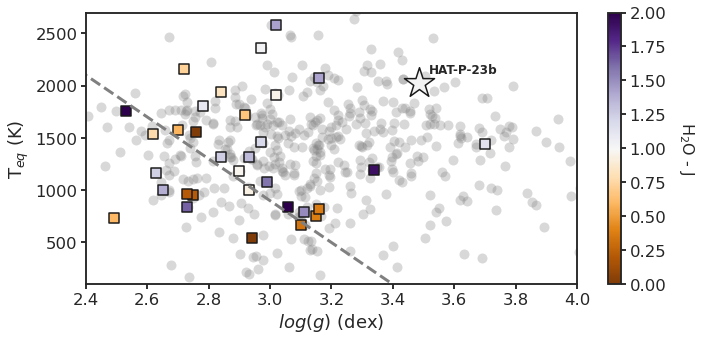

In [13]:
"""
Updated Stevenson+ 16 plot using the H2O-J measurements from 
Wakeford+ 2019
"""
fig, ax = plt.subplots(figsize=FIG_WIDE)

# Plot catalog targets
g_pop_pos_idxs = g_pop > 0.0  # Avoid taking log of invalid nums
logg_southworth = np.log10(100 * g_pop[g_pop_pos_idxs])  # log10(SI -> CGS)
T_eq_southworth = Teq_pop[g_pop_pos_idxs]
ax.plot(
    logg_southworth,
    T_eq_southworth,
    "o",
    color="gray",
    alpha=0.3,
    zorder=-10,
    ms=10,
    mew=0,
)

# Plot H2O-J information
points = ax.scatter(
    logg_wakeford,
    Teq_wakeford,
    c=H2O_J,
    marker="s",
    s=100,
    edgecolor="k",
    cmap="PuOr",
    vmin=0,
    vmax=2,
)
cbar = plt.colorbar(points)
cbar.set_label("H$_{2}$O - J", fontsize=16, labelpad=30, rotation=270)

# Plot HAT-P-23b for context
targ_coords = (3.485, 2027)
ax.scatter(
    *targ_coords,
    c="#F3F3F3",
    marker="*",
    s=1000,
    edgecolor="k",
    cmap="PuOr",
    vmin=0,
    vmax=2,
)
ax.annotate(
    "HAT-P-23b",
    xy=targ_coords,
    xytext=(10, 10),
    textcoords="offset points",
    # ha = "left",
    fontsize=12,
    weight="bold",
)

# Plot WASP-50
# targ_coords = (np.log10(100*30), 1381)
# ax.scatter(
#     *targ_coords,
#     c="g",
#     #marker="*",
#     s=200,
#     lw=0,
#     #cmap="PuOr",
#     vmin=0,
#     vmax=2,
# )
# ax.annotate(
#     "WASP-50b",
#     xy=targ_coords,
#     xytext=(10, 10),
#     textcoords="offset points",
#     ha = "right",
#     fontsize=12,
#     weight="bold",
# )

# Jupiter
# targ_coords = (np.log10(100*25), 150)
# ax.scatter(
#     *targ_coords,
#     c="r",
#     #marker="*",
#     s=200,
#     lw=0,
#     #cmap="PuOr",
#     vmin=0,
#     vmax=2,
# )

# Plot WASP-43
# targ_coords = df_wakeford.loc["WASP-43"][["logg", "T"]].values
# ax.annotate(
#     "WASP-43b",
#     xy=targ_coords,
#     xytext=(10, 10),
#     textcoords="offset points",
#     #ha = "right",
#     fontsize=12,
#     weight="bold",
# )
    
    
# Plot HD189733
# targ_coords = df_wakeford.loc["HD189733"][["logg", "T"]].values
# ax.annotate(
#     "HD189733",
#     xy=targ_coords,
#     #xytext=(10, 10),
#     #textcoords="offset points",
#     #ha = "right",
#     fontsize=12,
#     weight="bold",
# )

# Plot divide
m = (300 - 2100) / (3.3 - 2.4)
loggs = np.linspace(*ax.get_xlim(), 100)
Teqs = m * (loggs - 2.4) + 2100
ax.plot(loggs, Teqs, ls="dashed", lw=3, color="grey")

# Save
ax.set_xlim(2.4, 4.0)
ax.set_ylim(100, 2_700)
ax.set_xlabel("$log(g)$ (dex)")
ax.set_ylabel("T$_{eq}$ (K)")
fig.set_size_inches(FIG_WIDE)
utils.savefig("../paper/figures/cloudy_vs_clear/cloudy_vs_clear.pdf")